# Import Libraries

In [281]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import os
import ffn as ffn
import bt

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use
%matplotlib inline

import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")
import plotly.graph_objects as go

import yfinance as yf
import seaborn as sns
import monthly_returns_heatmap as mrh

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation

import hvplot.pandas


# Select Investment Style: Active/Passive

# 1. Data Access and Cleaning

## Download index for SPY and Factors ETF (Value, Momentum, Quality, Growth/High Dividend, Low Vol)

In [186]:
#download index price
stocks = ["FDL","IVE","IVW","MTUM","QUAL","SPY","USMV", "SIZE"]
end_date = datetime.now()
start_date = end_date + timedelta(-365 * 20)
data = yf.download(stocks, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                                        \
                 FDL        IVE        IVW MTUM QUAL SIZE         SPY USMV   
Date                                                                         
2000-08-22       NaN  40.029903  68.374657  NaN  NaN  NaN  102.734703  NaN   
2000-08-23       NaN  39.970325  68.967888  NaN  NaN  NaN  103.140663  NaN   
2000-08-24       NaN  39.751896  69.537399  NaN  NaN  NaN  103.461136  NaN   
2000-08-25       NaN  39.851204  69.383141  NaN  NaN  NaN  103.418442  NaN   
2000-08-28       NaN  40.099403  69.810287  NaN  NaN  NaN  103.770996  NaN   

           Close             ...       Open      Volume                    \
             FDL        IVE  ...        SPY USMV    FDL    IVE   IVW MTUM   
Date                         ...                                            
2000-08-22   NaN  63.000000  ...  150.56250  NaN    NaN   3900  1800  NaN   
2000-08-23   NaN  62.906250  ...  149.81250  NaN    NaN  26000  9900  NaN   
2000-08-24   NaN  62.562500  ...  151.15625  NaN    NaN   2500  6900  NaN   
2000-08-25   NaN  62.718750  ...  151.15625  NaN    NaN  21100  3000  NaN   
2000-08-28   NaN  63.109375  ...  151.25000  NaN    NaN  22100  2900  NaN   

                                    
           QUAL SIZE      SPY USMV  
Date                                
2000-08-22  NaN  NaN  3075300  NaN  
2000-08-23  NaN  NaN  5483200  NaN  
2000-08-24  NaN  NaN  4529000  NaN  
2000-08-25  NaN  NaN  2822200  NaN  
2000-08-28  NaN  NaN  5518700  NaN  

[5 rows x 48 columns]

In [187]:
#funds dataframe
funds_df = data['Close'].dropna()
funds_df.tail()

,FDL,IVE,IVW,MTUM,QUAL,SIZE,SPY,USMV
Date,,,,,,,,
2020-08-11,27.280001,115.930000,224.470001,138.080002,103.000000,94.779999,332.799988,63.669998
2020-08-12,27.389999,116.779999,228.750000,141.820007,104.290001,95.410004,337.440002,64.320000
2020-08-13,27.160000,115.879997,229.119995,142.559998,104.040001,95.120003,336.829987,64.199997
2020-08-14,27.200001,116.180000,228.899994,142.449997,103.989998,95.209999,336.839996,64.209999
2020-08-17,27.120001,115.879997,230.250000,145.039993,104.309998,95.449997,337.910004,64.510002


In [188]:
#return dataframe
funds_return = funds_df.pct_change().dropna()
funds_return.tail(10)

,FDL,IVE,IVW,MTUM,QUAL,SIZE,SPY,USMV
Date,,,,,,,,
2020-08-04,0.005285,0.005420,0.002228,0.004086,0.003663,0.003129,0.003863,0.004412
2020-08-05,0.000376,0.005391,0.007202,0.001473,0.009764,0.008819,0.006211,-0.000784
2020-08-06,-0.000375,0.000088,0.010946,0.003503,0.005958,-0.001599,0.006685,0.002512
2020-08-07,0.015396,0.011866,-0.006767,-0.008308,0.002719,0.005766,0.000718,0.007518
2020-08-10,0.010725,0.009642,-0.001451,-0.007885,0.002421,0.008387,0.002989,-0.001088
2020-08-11,-0.001829,-0.002581,-0.011842,-0.020153,-0.005023,-0.002106,-0.008255,-0.009182
2020-08-12,0.004032,0.007332,0.019067,0.027086,0.012524,0.006647,0.013942,0.010209
2020-08-13,-0.008397,-0.007707,0.001617,0.005218,-0.002397,-0.003040,-0.001808,-0.001866
2020-08-14,0.001473,0.002589,-0.000960,-0.000772,-0.000481,0.000946,0.000030,0.000156


# 2. Evaluating passive and active funds

## Analyse historical risk/return of passive vs active funds

We are looking at return and risk characteristic of S&P index, a passive fund, and active funds like Value funds (VL), Momentum funds (MT), Qyality fund (QL), Growth (GR), and High Dividend (HD). Price and return data are daily frequency covering 07/18/2013 to the most recent date. 

In [189]:
#reorder the columns of price dataframe into fund groups
funds_df.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_df = funds_df[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_df.head()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-18,79.949997,53.040001,54.110001,33.849998,21.379999,50.150002,88.529999,168.869995
2013-07-19,80.230003,53.040001,54.349998,33.930000,21.430000,49.759998,88.500000,169.169998
2013-07-22,80.400002,54.000000,54.419998,33.939999,21.430000,50.000000,88.660004,169.500000
2013-07-23,80.419998,54.000000,54.330002,33.900002,21.510000,49.919998,88.339996,169.139999
2013-07-24,79.900002,54.000000,54.139999,33.680000,21.360001,49.849998,88.250000,168.520004


In [190]:
#reorder the columns of return dataframe into fund groups
funds_return.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_return = funds_return[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_return.head()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-19,0.003502,0.0000,0.004435,0.002363,0.002339,-0.007777,-0.000339,0.001777
2013-07-22,0.002119,0.0181,0.001288,0.000295,0.000000,0.004823,0.001808,0.001951
2013-07-23,0.000249,0.0000,-0.001654,-0.001178,0.003733,-0.001600,-0.003609,-0.002124
2013-07-24,-0.006466,0.0000,-0.003497,-0.006490,-0.006973,-0.001402,-0.001019,-0.003666
2013-07-25,0.002128,0.0000,0.007573,0.003860,0.004213,0.005216,0.002946,0.002433


Return of every active fund is positively correlated to S&P. 

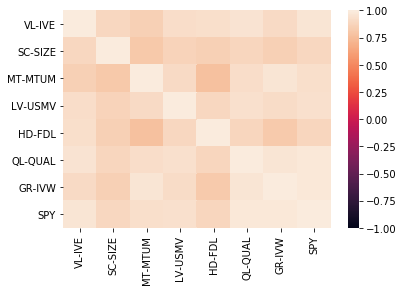

In [191]:
# return correlation, beta: positive correlation. High Dividend EFTs seems to correlated more 
correlation = funds_return.corr()
sns.heatmap(correlation, vmin =-1, vmax=1)

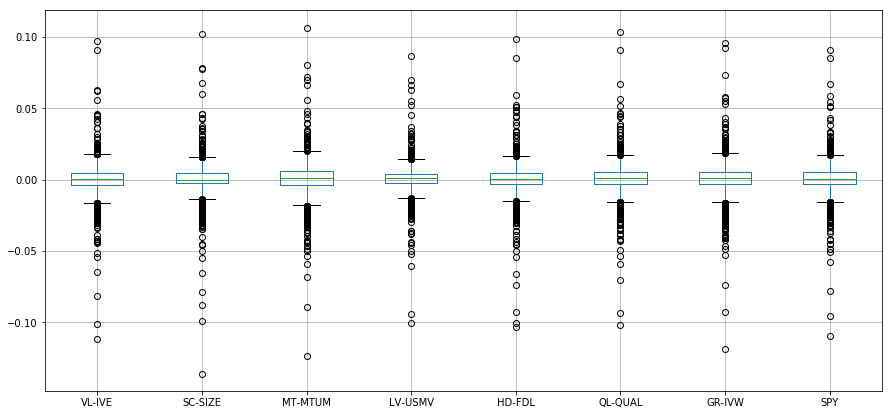

In [192]:
#distribution of returns
boxplot_return_dist = funds_return.boxplot(figsize = (15,7), grid = True)

Looking at fund's return volatility in the past 7 years, all active funds have similar vol as S&P except Low Vol fund which try to capture beta by low-volatile stick in nature. 

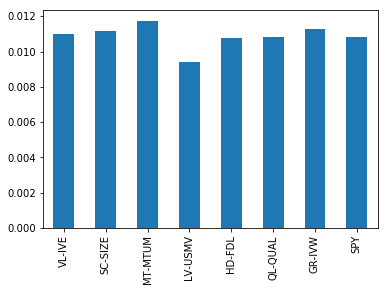

In [193]:
#long-term volatilityof return
funds_return_std = funds_return.std()
funds_return_std.plot(kind="bar")

In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

Active funds could outperform S&P by 4% annually. Annualized return from investing in S&P in the past 7 years is 10.29% (annualized return since inception). The best performer among active funds is Momentum (MT-MTUM) which generate annualized return at 14.60%. Follow by Growth (GR-IVW, 14.37%), Quality (QL-QUAL, 10.91%). Even Value funds underperform S&P but annualized return are still positive. Majority of High Dividend funds generate loss.

However, rank of performance change in recent shorter horizon. Outperformance of Momentum fund is pretty robust, except in the past 3 months that Momentum Fund (17.72%) underperform S&P (18.20%). Growth Fund (21.41%) and Small Cap Fund (20.72%) are the best performers in the past 3 months as propect of economic growth improved.

Growth fund is also performed slightly better than market index during tough time. Maximum Drawdown of Momentum fund is -34.08%, slightly than -34.10% of S&P index. However, MDD is shallower for HD-HYG (-28.05%). In contrast, MDD are deeper in HD-FDL (-41.40%) and HD-SDIV (-69.08%).

In [194]:
#backtesting
backtest = funds_df.calc_stats()
backtest.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         44.94%      79.96%      168.05%     90.58%      26.85%      108.00%     160.08%     100.10%
Daily Sharpe         0.39        0.56        0.84        0.69        0.28        0.69        0.85        0.66
Daily Sortino        0.58        0.81        1.28        1.03        0.42        1.05        1.28        0.98
CAGR                 5.38%       8.65%       14.94%      9.53%       3.41%       10.89%      14.45

Examine risk and return characteristics of passive and active funds in different economic/market scenarios in the past to get better idea how Momentum, Quality and Growth funds outperform market index. Given limitation of fund’s data which allow us to go back just 7 years, we set scenarios into 3 scenarios. (1) Taper Tantrum which represent the period of high market volatility in 2013  as investors feared that Fed will withdraw large amount of support in bond market and could increase funding rate. (2) Hike cycle in 2016-18  which represent period of good economic growth that Fed feel confident to increase policy rate. (3) Recent market turmoil during COVID pandemic which cause VIX index to spike in Mar. 

During Taper Tantrum period in 2013, Momentum (25.66% since incep ann) and Quality (30.10%) funds outperformed S&P (21.78%). Value fund (15.79-15.95%) turned out underperformed market index and were more volatile. Similar conclusion seen in pandemic scenario. Momentum (25.66%) also outperformed S&P (21.78%) during hiking cycle together with Low Vol (8.29%) and Growth (9.86%).

During market turmoil, Growth Fund has smallest MDD (-25.73%) and slightly lower than S&P (-28.74%).  

In [195]:
#economic cycle:cutting cycle(none),Taper Tantrum(2013), goldilock/hike cycle(2016-18), pandemic(Mar-May2020)
#slice return datafram into scenarios
funds_return_taper_tantrum = funds_return.loc['20130718':'20131231']
funds_return_hike_cycle = funds_return.loc['20160102':'20181231']
funds_return_pandemic = funds_return.loc['20200302':'20200330']
#slice price dataframe into scenarios
funds_df_taper_tantrum = funds_df.loc['20130718':'20131231']
funds_df_hike_cycle = funds_df.loc['20160102':'20181231']
funds_df_pandemic = funds_df.loc['20200302':'20200330']

In [196]:
#backtest funds during Taper Tantrum
backtest_taper_tantrum = funds_df_taper_tantrum.calc_stats()
backtest_taper_tantrum.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         6.89%       8.45%       10.94%      4.87%       2.48%       12.70%      11.54%      9.37%
Daily Sharpe         1.49        1.81        2.34        1.19        0.63        2.84        2.48        2.04
Daily Sortino        2.81        2.82        4.35        2.42        1.11        5.04        4.66        3.81
CAGR                 15.79%      19.53%      25.66%      11.04%      5.54%       30.10%      27.17% 

In [197]:
#backtest funds during hiking cycle
backtest_hike_cycle = funds_df_hike_cycle.calc_stats()
backtest_hike_cycle.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04
End                  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         15.61%      21.25%      39.58%      26.88%      15.87%      20.65%      32.46%      24.33%
Daily Sharpe         0.45        0.60        0.80        0.83        0.50        0.56        0.73        0.62
Daily Sortino        0.68        0.91        1.22        1.26        0.75        0.84        1.10        0.94
CAGR                 4.97%       6.66%       11.80%      8.29%       5.05%       6.48%       9.86% 

In [198]:
#backtest funds during pandemic
backtest_pandemic = funds_df_pandemic.calc_stats()
backtest_pandemic.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02
End                  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -18.21%     -20.07%     -13.34%     -14.37%     -21.83%     -14.13%     -12.98%     -15.35%
Daily Sharpe         -2.16       -2.24       -1.38       -1.86       -2.76       -1.62       -1.40       -1.81
Daily Sortino        -3.70       -3.60       -2.39       -3.20       -4.63       -2.90       -2.42       -3.09
CAGR                 -92.73%     -94.62%     -84.54%     -86.78%     -95.98%     -86.30%     -83

Interestingly, every funds correalted more with S&P during crisis time when volatiliry in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

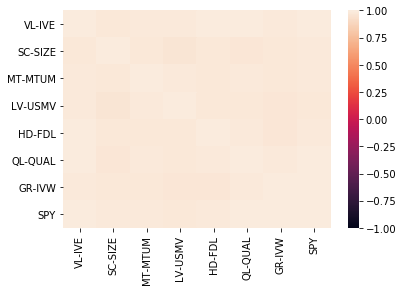

In [199]:
#correlation in different periods/cycle
correlation_pandemic = funds_return_pandemic.corr()
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

In [200]:
funds_df.head(2)

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-18,79.949997,53.040001,54.110001,33.849998,21.379999,50.150002,88.529999,168.869995
2013-07-19,80.230003,53.040001,54.349998,33.930000,21.430000,49.759998,88.500000,169.169998


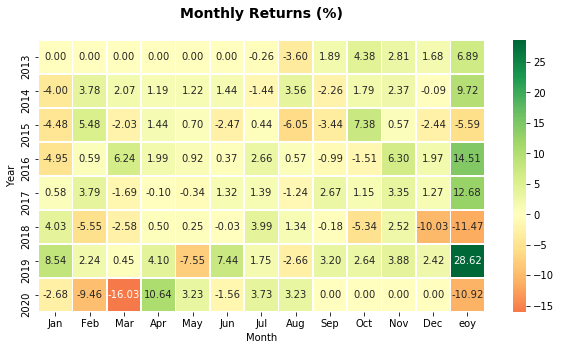

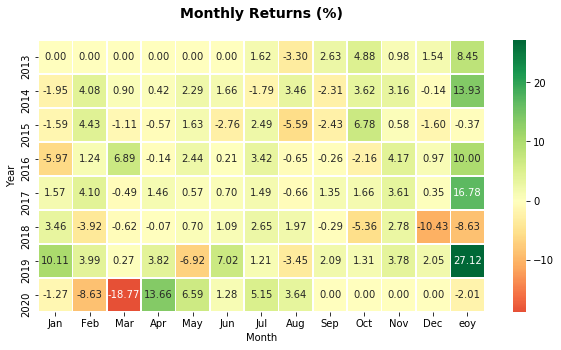

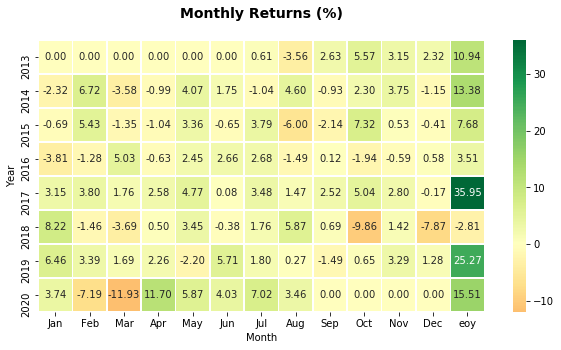

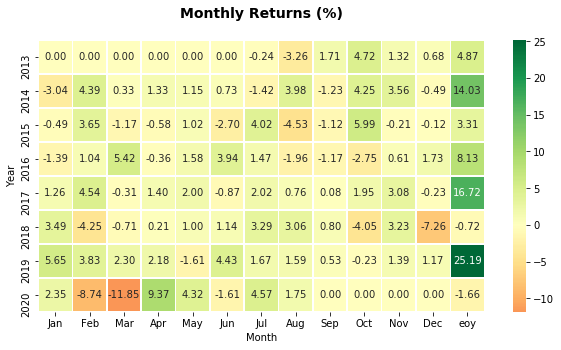

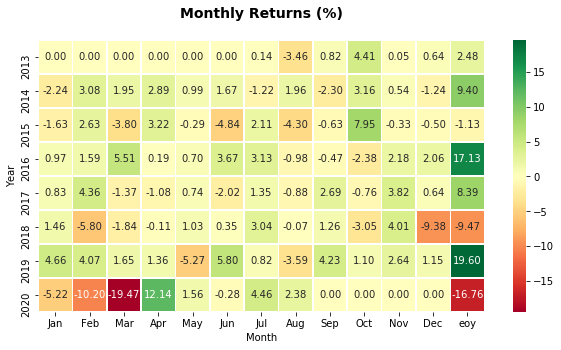

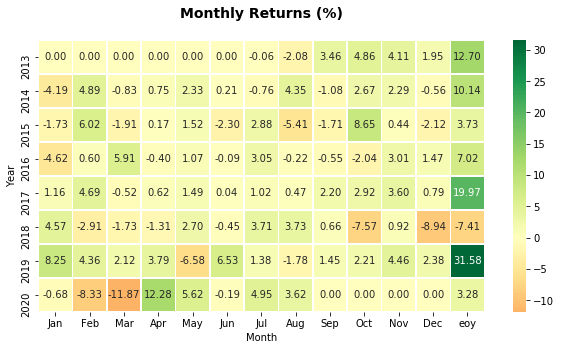

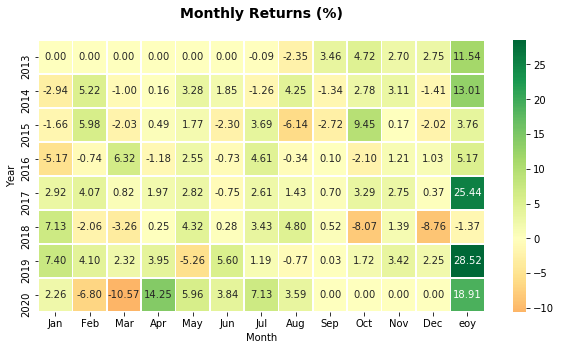

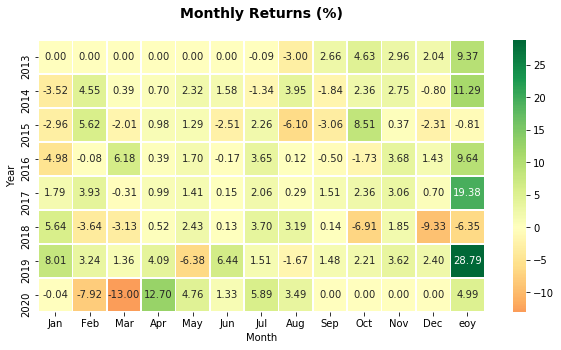

In [201]:
FoF_returns = funds_df.pct_change()
for column in FoF_returns:
    columnSeries = FoF_returns[column]
    mrh.plot(columnSeries, figsize=(10,5), eoy = True)

## Findings Summary

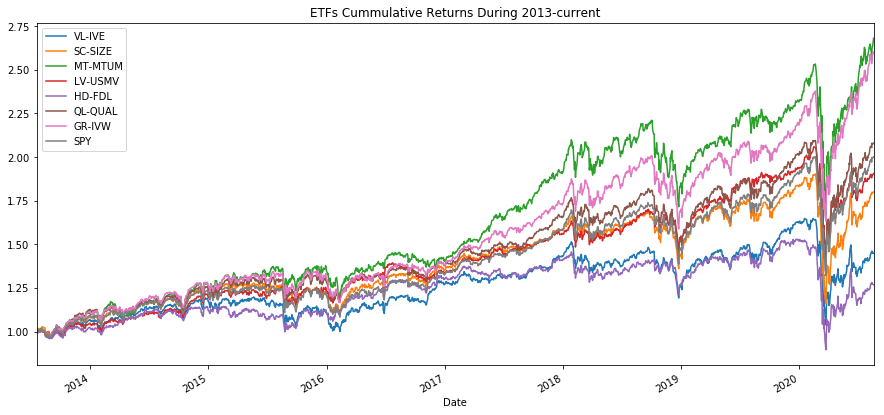

In [202]:
# Cummulative return: Growth, Momentum and Qualirty ETFs outperform SPY during 2013-current.
funds_return_cum = (1+funds_return).cumprod()
funds_return_cum.plot(figsize = (15,7), title = "ETFs Cummulative Returns During 2013-current")

### In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

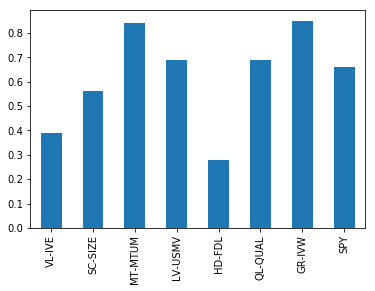

In [203]:
# Sharpe ratio: Risk/return tradeoff are less attractive in High Dividend funds. Most attractive in Momentum, Quality and Growth funds.
funds_return_sharpe = round((funds_return.mean()*252)/(funds_return.std() * np.sqrt(252)),2)
funds_return_sharpe.plot(kind="bar")

### Outperformance of Momentum fund is pretty robust under different scenarios, except in the past 3 months that Momentum Fund underperform S&P. Growth Fund and Small Cap Fund are the best performers in the past 3 months as propect of economic growth improved.

In [204]:
funds_df_3m = funds_df.loc['20200514':'20200814']
total_return_all = round(ffn.core.calc_total_return(funds_df)*100,2)
total_return_3m = round(ffn.core.calc_total_return(funds_df_3m)*100,2)
total_return_taper_tantrum = round(ffn.core.calc_total_return(funds_df_taper_tantrum)*100,2)
total_return_pandemic = round(ffn.core.calc_total_return(funds_df_pandemic)*100,2)
total_return_hike_cycle = round(ffn.core.calc_total_return(funds_df_hike_cycle)*100,2)
total_return_scenarios = pd.concat([total_return_all, total_return_3m, total_return_taper_tantrum,total_return_pandemic,total_return_hike_cycle], axis = 1,keys=['Total','Last 3M','Taper Tantum','Pandemic','Hike Cycle'])
total_return_scenarios

,Total,Last 3M,Taper Tantum,Pandemic,Hike Cycle
VL-IVE,44.94,14.05,6.89,-18.21,15.61
SC-SIZE,79.96,20.72,8.45,-20.07,21.25
MT-MTUM,168.05,17.72,10.94,-13.34,39.58
LV-USMV,90.58,10.88,4.87,-14.37,26.88
HD-FDL,26.85,15.01,2.48,-21.83,15.87
QL-QUAL,108.00,15.81,12.70,-14.13,20.65
GR-IVW,160.08,21.41,11.54,-12.98,32.46
SPY,100.10,18.20,9.37,-15.35,24.33


### Less downside risk is seen in Growth Fund during market turmoil. However, every funds correalted more with S&P during crisis time when volatility in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

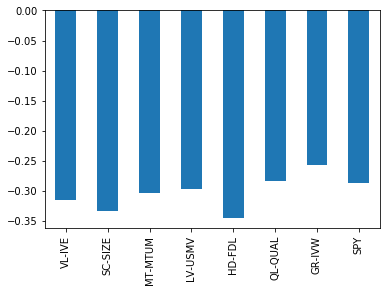

In [205]:
ffn.core.calc_max_drawdown(funds_df_pandemic).plot(kind="bar")

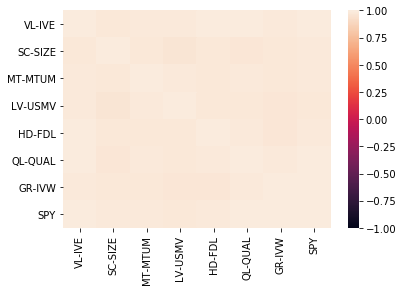

In [206]:
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

# 3. Simulated Return and Portfolio Optimization

## Projected Return of Equal-Weight Portfolio

In [207]:
# Calculate the daily roi for the stocks
funds_return.head()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-19,0.003502,0.0000,0.004435,0.002363,0.002339,-0.007777,-0.000339,0.001777
2013-07-22,0.002119,0.0181,0.001288,0.000295,0.000000,0.004823,0.001808,0.001951
2013-07-23,0.000249,0.0000,-0.001654,-0.001178,0.003733,-0.001600,-0.003609,-0.002124
2013-07-24,-0.006466,0.0000,-0.003497,-0.006490,-0.006973,-0.001402,-0.001019,-0.003666
2013-07-25,0.002128,0.0000,0.007573,0.003860,0.004213,0.005216,0.002946,0.002433


In [208]:
# Display sample data
funds_return.sample()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2015-07-24,-0.01186,0.0,-0.002312,-0.003623,-0.006082,-0.014923,-0.008506,-0.010372


In [209]:
# Compute daily roi volatility
funds_return_vol= funds_return.std()
funds_return_vol

VL-IVE     0.011013
SC-SIZE    0.011136
MT-MTUM    0.011740
LV-USMV    0.009388
HD-FDL     0.010750
QL-QUAL    0.010826
GR-IVW     0.011261
SPY        0.010817
dtype: float64

In [210]:
funds_return_vol_fdl = funds_return["HD-FDL"].std()
funds_return_vol_fdl

0.010749824790623022

In [211]:
funds_return_vol_ive = funds_return["VL-IVE"].std()
funds_return_vol_ive

0.011012639597596893

In [212]:
funds_return_vol_ivw = funds_return["GR-IVW"].std()
funds_return_vol_ivw

0.011261091286647896

In [213]:
funds_return_vol_mtum = funds_return["MT-MTUM"].std()
funds_return_vol_mtum

0.011739653172675725

In [214]:
funds_return_vol_qual = funds_return["QL-QUAL"].std()
funds_return_vol_qual

0.010825603559522739

In [215]:
funds_return_vol_size = funds_return["SC-SIZE"].std()
funds_return_vol_size

0.011136318554662347

In [216]:
funds_return_vol_spy = funds_return["SPY"].std()
funds_return_vol_spy

0.010817067408360186

In [217]:
funds_return_vol_usmv = funds_return["LV-USMV"].std()
funds_return_vol_usmv

0.00938825205547279

In [218]:
# Compute daily roi average
funds_daily_return_fdl = funds_return["HD-FDL"].mean()
funds_daily_return_fdl

0.00019157553133718582

In [219]:
funds_daily_return_ive = funds_return["VL-IVE"].mean()
funds_daily_return_ive

0.0002691798134677326

In [220]:
funds_daily_return_ivw = funds_return["GR-IVW"].mean()
funds_daily_return_ivw

0.0005999058952389614

In [221]:
funds_daily_return_mtum = funds_return["MT-MTUM"].mean()
funds_daily_return_mtum

0.0006223587482682637

In [222]:
funds_daily_return_qual = funds_return["QL-QUAL"].mean()
funds_daily_return_qual

0.00046958321433772095

In [223]:
funds_daily_return_size = funds_return["SC-SIZE"].mean()
funds_daily_return_size

0.000392243299431613

In [224]:
funds_daily_return_spy = funds_return["SPY"].mean()
funds_daily_return_spy

0.00044793945059953003

In [225]:
funds_daily_return_usmv = funds_return["LV-USMV"].std()
funds_daily_return_usmv

0.00938825205547279

In [226]:
# Save the last day's closing price
last_day_fdl = funds_return["HD-FDL"][-1]
last_day_fdl

-0.0029411735831660346

In [227]:
last_day_ive = funds_return["VL-IVE"][-1]
last_day_ive

-0.002582226295143597

In [228]:
last_day_ivw = funds_return["GR-IVW"][-1]
last_day_ivw

0.0058977987746304805

In [229]:
last_day_mtum = funds_return["MT-MTUM"][-1]
last_day_mtum

0.018181792863299684

In [230]:
last_day_qual = funds_return["QL-QUAL"][-1]
last_day_qual

0.00307721609191125

In [231]:
last_day_size = funds_return["SC-SIZE"][-1]
last_day_size

0.0025207212065678775

In [232]:
last_day_spy = funds_return["SPY"][-1]
last_day_spy

0.0031766041320859806

In [233]:
last_day_usmv = funds_return["LV-USMV"][-1]
last_day_usmv

0.0046722170383952655

In [234]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252
monte_carlo = pd.DataFrame()
simulated_price_df= pd.DataFrame()
portfolio_cumulative_returns= pd.DataFrame()

In [235]:
# Run the Monte Carlo Simulation
for simulations in range(number_simulations):
    simulated_fdl_prices=[last_day_fdl]
    simulated_ive_prices=[last_day_ive]
    simulated_ivw_prices=[last_day_ivw]
    simulated_mtum_prices=[last_day_mtum]
    simulated_qual_prices=[last_day_qual]
    simulated_size_prices=[last_day_size]    
    simulated_spy_prices=[last_day_spy]
    simulated_usmv_prices=[last_day_usmv]
    
    for days in range(number_records):
        simulated_fdl_price=simulated_fdl_prices[-1]*(1+np.random.normal(abs(funds_daily_return_fdl),abs(funds_return_vol_fdl)))
        simulated_ive_price =simulated_ive_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ive),abs(funds_return_vol_ive)))
        simulated_ivw_price =simulated_ivw_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ivw),abs(funds_return_vol_ivw)))
        simulated_mtum_price=simulated_mtum_prices[-1]*(1+np.random.normal(abs(funds_daily_return_mtum),abs(funds_return_vol_mtum)))
        simulated_qual_price=simulated_qual_prices[-1]*(1+np.random.normal(abs(funds_daily_return_qual),abs(funds_return_vol_qual)))
        simulated_size_price=simulated_size_prices[-1]*(1+np.random.normal(abs(funds_daily_return_size),abs(funds_return_vol_size)))
        simulated_spy_price =simulated_spy_prices[-1]*(1+np.random.normal(abs(funds_daily_return_spy),abs(funds_return_vol_spy)))
        simulated_usmv_price=simulated_usmv_prices[-1]*(1+np.random.normal(abs(funds_daily_return_usmv),abs(funds_return_vol_usmv)))  
        
        
        simulated_fdl_prices.append(simulated_fdl_price)
        simulated_ive_prices.append(simulated_ive_price)
        simulated_ivw_prices.append(simulated_ivw_price)
        simulated_mtum_prices.append(simulated_mtum_price)
        simulated_qual_prices.append(simulated_qual_price)
        simulated_size_prices.append(simulated_size_price)   
        simulated_spy_prices.append(simulated_spy_price)
        simulated_usmv_prices.append(simulated_usmv_price)
        
     
        
    simulated_price_df["HD-FDL"]=simulated_fdl_prices
    simulated_price_df["VL-IVE"]=simulated_ive_prices
    simulated_price_df["GR-IVW"]=simulated_ivw_prices
    simulated_price_df["MT-MTUM"]=simulated_mtum_prices
    simulated_price_df["QL-QUAL"]=simulated_qual_prices
    simulated_price_df["SC-SIZE"]=simulated_size_prices
    simulated_price_df["SPY"]= simulated_spy_prices
    simulated_price_df["LV-USMV"]=simulated_usmv_prices
    
    simulated_daily_returns=simulated_price_df.pct_change()
    weights=[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125]
    portfolio_daily_returns=simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[simulations]= (1+portfolio_daily_returns.fillna(0)).cumprod()
   

In [236]:
len(simulated_ivw_prices)

253

In [237]:
abs(funds_return_vol_spy)

0.010817067408360186

In [238]:
# Check that the simulation ran successfully
simulated_price_df.head()

,HD-FDL,VL-IVE,GR-IVW,MT-MTUM,QL-QUAL,SC-SIZE,SPY,LV-USMV
0,-0.002941,-0.002582,0.005898,0.018182,0.003077,0.002521,0.003177,0.004672
1,-0.002954,-0.002597,0.005847,0.018188,0.003067,0.002531,0.003165,0.004696
2,-0.002951,-0.002638,0.005882,0.018340,0.003099,0.002589,0.003188,0.004672
3,-0.002931,-0.002645,0.005971,0.018697,0.003070,0.002576,0.003142,0.004647
4,-0.002953,-0.002600,0.005968,0.018769,0.003077,0.002557,0.003115,0.004728


In [239]:
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
248,1.487723,1.495655,1.524226,1.447704,1.391570,1.602482,1.403242,1.542672,1.345625,1.324358,...,1.399890,1.503777,1.566712,1.678727,1.437034,1.415571,1.645441,1.428051,1.406252,1.475333
249,1.492752,1.491377,1.522974,1.443450,1.385196,1.618295,1.406618,1.537434,1.358380,1.333108,...,1.402312,1.508895,1.571949,1.680515,1.453906,1.422177,1.646824,1.437638,1.404566,1.481225
250,1.501787,1.480839,1.521823,1.442868,1.387581,1.617571,1.400746,1.534187,1.367777,1.344805,...,1.397397,1.516984,1.569499,1.692550,1.461227,1.425932,1.656772,1.450629,1.401930,1.478261
251,1.511774,1.488313,1.518642,1.442958,1.381686,1.617423,1.408795,1.526879,1.369929,1.342865,...,1.406158,1.522135,1.568044,1.684717,1.455863,1.428395,1.670287,1.454793,1.412579,1.492465
252,1.525142,1.483396,1.518827,1.448329,1.382892,1.610337,1.414186,1.527341,1.369010,1.348669,...,1.416912,1.519464,1.574803,1.682711,1.467388,1.435062,1.659931,1.467814,1.421536,1.501119


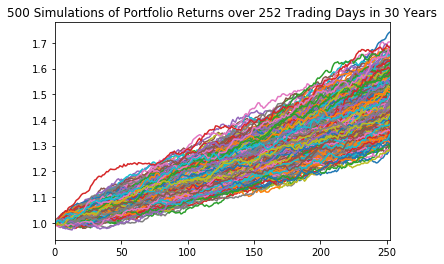

In [240]:
# Visualize the Simulation
plot_title=f"{number_simulations} Simulations of Portfolio Returns over {number_records} Trading Days in 30 Years"
portfolio_cumulative_returns.plot(legend=None,title=plot_title)

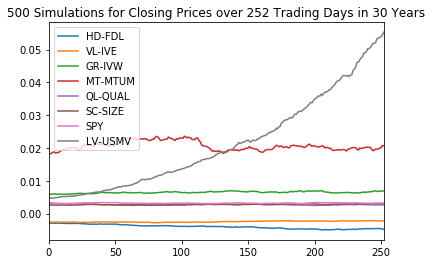

In [241]:
plot_title2=f"{number_simulations} Simulations for Closing Prices over {number_records} Trading Days in 30 Years"
simulated_price_df.plot(title=plot_title2)

In [242]:
# last row for the cumulative returns
simulated_price_df[-1:]

,HD-FDL,VL-IVE,GR-IVW,MT-MTUM,QL-QUAL,SC-SIZE,SPY,LV-USMV
252,-0.004809,-0.002251,0.006927,0.020641,0.002649,0.002989,0.003177,0.055265


In [243]:
cumulative_ret = portfolio_cumulative_returns.iloc[-1,:]

In [244]:
# Display the 90% confidence interval for the ending returns
confidence_interval= cumulative_ret.quantile(q=[0.05,0.95])
confidence_interval

0.05    1.334388
0.95    1.621089
Name: 252, dtype: float64

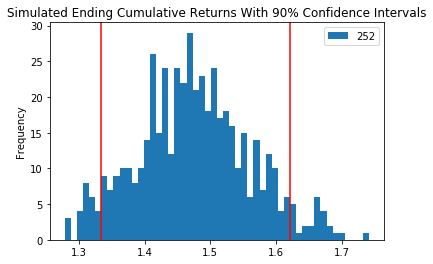

In [245]:
# Visualize the distribution of the ending returns
cumulative_ret.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval.iloc[0],color='r')
plt.axvline(confidence_interval.iloc[1],color='r')

## Optimization: Max Sharpe and Min Vol Portfolios

In [246]:
#Calculate mean returns and covariances of all stocks
funds_df = data['Close'].dropna()
funds_return = funds_df.pct_change().dropna()
mean_returns = funds_return.mean()
cov_matrix = funds_return.cov()
mean_returns
cov_matrix

,FDL,IVE,IVW,MTUM,QUAL,SIZE,SPY,USMV
FDL,0.000116,0.000110,0.000100,0.000098,0.000103,0.000103,0.000104,0.000091
IVE,0.000110,0.000121,0.000113,0.000111,0.000114,0.000110,0.000115,0.000096
IVW,0.000100,0.000113,0.000127,0.000127,0.000118,0.000107,0.000119,0.000097
MTUM,0.000098,0.000111,0.000127,0.000138,0.000118,0.000107,0.000119,0.000100
QUAL,0.000103,0.000114,0.000118,0.000118,0.000117,0.000107,0.000115,0.000095
SIZE,0.000103,0.000110,0.000107,0.000107,0.000107,0.000124,0.000108,0.000091
SPY,0.000104,0.000115,0.000119,0.000119,0.000115,0.000108,0.000117,0.000095
USMV,0.000091,0.000096,0.000097,0.000100,0.000095,0.000091,0.000095,0.000088


In [247]:
# Compute daily volatility
std_return = funds_return.std()
std_return

FDL     0.010750
IVE     0.011013
IVW     0.011261
MTUM    0.011740
QUAL    0.010826
SIZE    0.011136
SPY     0.010817
USMV    0.009388
dtype: float64

In [248]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 1000
simulation_res = np.zeros((4+len(stocks)-1,num_iterations))

In [249]:
#Compute stock returns and print the returns in percentage format
funds_return = funds_df.pct_change().dropna()
print (funds_return.round(4)*100)

             FDL   IVE   IVW  MTUM  QUAL  SIZE   SPY  USMV
Date                                                      
2013-07-19  0.23  0.35 -0.03  0.44 -0.78  0.00  0.18  0.24
2013-07-22  0.00  0.21  0.18  0.13  0.48  1.81  0.20  0.03
2013-07-23  0.37  0.02 -0.36 -0.17 -0.16  0.00 -0.21 -0.12
2013-07-24 -0.70 -0.65 -0.10 -0.35 -0.14  0.00 -0.37 -0.65
2013-07-25  0.42  0.21  0.29  0.76  0.52  0.00  0.24  0.39
2013-07-26  0.37 -0.06  0.15  0.24 -0.48  0.00  0.11  0.21
2013-07-29 -0.05 -0.35 -0.28 -0.15  0.36 -0.46 -0.31 -0.15
2013-07-30 -0.19 -0.09  0.17 -0.20  0.40  0.00  0.00  0.12
2013-07-31 -0.33  0.09 -0.10 -0.09 -0.26  0.28  0.07 -0.30
2013-08-01  0.89  1.25  1.07  0.84  0.00  0.00  1.16  0.71
2013-08-02  0.19  0.04  0.31  0.47  1.20  0.00  0.17  0.00
2013-08-05 -0.37 -0.16 -0.06 -0.29  0.02  1.08 -0.15 -0.09
2013-08-06 -0.46 -0.61 -0.42 -0.36 -0.53  0.00 -0.57 -0.26
2013-08-07  0.09 -0.30 -0.41 -0.36 -0.42  0.00 -0.32 -0.35
2013-08-08 -0.05  0.31  0.36  0.11  0.48  0.00  0.37  0.

In [250]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(8))
        weights /= np.sum(weights)
#Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
#Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
#Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
#Save the weights in the array
        for j in range(len(weights)):
                simulation_res[j+3,i] = weights[j]

In [251]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3], stocks[4], stocks[5], stocks[6], stocks[7]])
sim_frame.tail (5)

,ret,stdev,sharpe,FDL,IVE,IVW,MTUM,QUAL,SPY,USMV,SIZE
995,0.000469,0.010466,0.044834,0.018445,0.007769,0.106684,0.154500,0.209434,0.266390,0.107386,0.129392
996,0.000411,0.010241,0.040139,0.164665,0.075223,0.023188,0.178185,0.028702,0.138213,0.182885,0.208938
997,0.000437,0.010616,0.041204,0.181334,0.170040,0.199191,0.223075,0.089792,0.069366,0.045769,0.021433
998,0.000446,0.010598,0.042056,0.034684,0.162212,0.267113,0.027307,0.143153,0.193498,0.123675,0.048359
999,0.000421,0.010638,0.039591,0.066295,0.246698,0.230969,0.050226,0.090518,0.199838,0.107027,0.008429


In [252]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret       0.000536
stdev     0.010940
sharpe    0.049039
FDL       0.024370
IVE       0.087583
IVW       0.288755
MTUM      0.429340
QUAL      0.005448
SPY       0.125974
USMV      0.005014
SIZE      0.033516
Name: 107, dtype: float64
The portfolio for min risk:
 ret       0.000375
stdev     0.010085
sharpe    0.037144
FDL       0.215873
IVE       0.142431
IVW       0.177889
MTUM      0.000893
QUAL      0.017117
SPY       0.147516
USMV      0.015345
SIZE      0.282936
Name: 901, dtype: float64


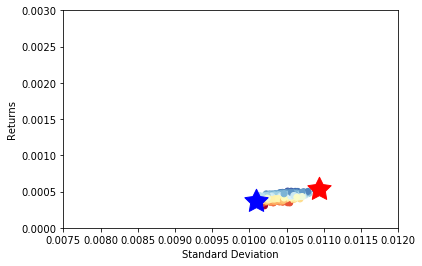

In [253]:
#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.ylim(0,.003)
plt.xlim(0.0075,0.012)
#Plot a red star to highlight position of the portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=600)
#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=600)
plt.show()

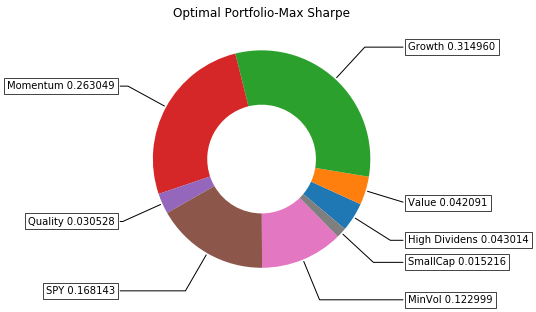

In [254]:
max_sharpe_w_pie , ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))

lebel = ["High Dividens 0.043014","Value 0.042091","Growth 0.314960","Momentum 0.263049","Quality 0.030528","SPY 0.168143","MinVol 0.122999","SmallCap 0.015216"]
        
data = [0.043014,0.042091,0.314960,0.263049,0.030528,0.168143,0.122999,0.015216]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lebel[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Optimal Portfolio-Max Sharpe")

plt.show()

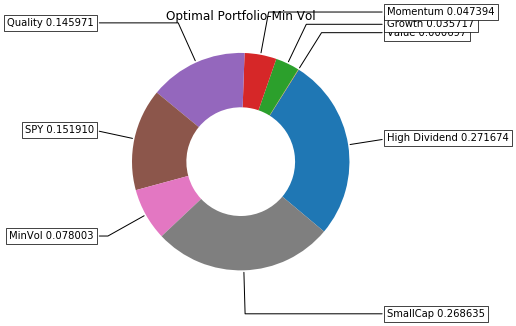

In [255]:
min_vol_w_pie, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))

lebel = ["High Dividend 0.271674","Value 0.000697","Growth 0.035717","Momentum 0.047394","Quality 0.145971","SPY 0.151910","MinVol 0.078003","SmallCap 0.268635"]
        
data = [0.271674,0.000697,0.035717,0.047394,0.145971,0.151910,0.078003,0.268635]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lebel[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Optimal Portfolio-Min Vol")

plt.show()

## Projected Return of Max Sharpe Portfolio

In [256]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252
monte_carlo_max_sharpe = pd.DataFrame()
simulated_price_df_max_sharpe= pd.DataFrame()

In [257]:
# Run the Monte Carlo Simulation for Max Sharpe Port
# "FDL 0.043014","IVE 0.042091","IVW 0.314960","MTUM 0.263049","QUAL 0.030528","SPY 0.168143","USMV 0.122999","SIZE 0.015216"

for simulations in range(number_simulations):
    simulated_fdl_prices=[last_day_fdl]
    simulated_ive_prices=[last_day_ive]
    simulated_ivw_prices=[last_day_ivw]
    simulated_mtum_prices=[last_day_mtum]
    simulated_qual_prices=[last_day_qual]
    simulated_size_prices=[last_day_size]    
    simulated_spy_prices=[last_day_spy]
    simulated_usmv_prices=[last_day_usmv]
    
    for days in range(number_records):
        simulated_fdl_price=simulated_fdl_prices[-1]*(1+np.random.normal(abs(funds_daily_return_fdl),abs(funds_return_vol_fdl)))
        simulated_ive_price =simulated_ive_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ive),abs(funds_return_vol_ive)))
        simulated_ivw_price =simulated_ivw_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ivw),abs(funds_return_vol_ivw)))
        simulated_mtum_price=simulated_mtum_prices[-1]*(1+np.random.normal(abs(funds_daily_return_mtum),abs(funds_return_vol_mtum)))
        simulated_qual_price=simulated_qual_prices[-1]*(1+np.random.normal(abs(funds_daily_return_qual),abs(funds_return_vol_qual)))
        simulated_size_price=simulated_size_prices[-1]*(1+np.random.normal(abs(funds_daily_return_size),abs(funds_return_vol_size)))
        simulated_spy_price =simulated_spy_prices[-1]*(1+np.random.normal(abs(funds_daily_return_spy),abs(funds_return_vol_spy)))
        simulated_usmv_price=simulated_usmv_prices[-1]*(1+np.random.normal(abs(funds_daily_return_usmv),abs(funds_return_vol_usmv)))  
        
        
        simulated_fdl_prices.append(simulated_fdl_price)
        simulated_ive_prices.append(simulated_ive_price)
        simulated_ivw_prices.append(simulated_ivw_price)
        simulated_mtum_prices.append(simulated_mtum_price)
        simulated_qual_prices.append(simulated_qual_price)
        simulated_size_prices.append(simulated_size_price)   
        simulated_spy_prices.append(simulated_spy_price)
        simulated_usmv_prices.append(simulated_usmv_price)
        
     
        
    simulated_price_df_max_sharpe["HD-FDL"]=simulated_fdl_prices
    simulated_price_df_max_sharpe["VL-IVE"]=simulated_ive_prices
    simulated_price_df_max_sharpe["GR-IVW"]=simulated_ivw_prices
    simulated_price_df_max_sharpe["MT-MTUM"]=simulated_mtum_prices
    simulated_price_df_max_sharpe["QL-QUAL"]=simulated_qual_prices
    simulated_price_df_max_sharpe["SC-SIZE"]=simulated_size_prices
    simulated_price_df_max_sharpe["SPY"]= simulated_spy_prices
    simulated_price_df_max_sharpe["LV-USMV"]=simulated_usmv_prices
    
    simulated_daily_returns_max_sharpe=simulated_price_df_max_sharpe.pct_change()
    weights_max_sharpe=[0.043014,0.042091,0.314960,0.263049,0.030528,0.015216,0.168143,0.122999]
    portfolio_daily_returns_max_sharpe =simulated_daily_returns_max_sharpe.dot(weights_max_sharpe)
    monte_carlo_max_sharpe[simulations]= (1+portfolio_daily_returns_max_sharpe.fillna(0)).cumprod()
   

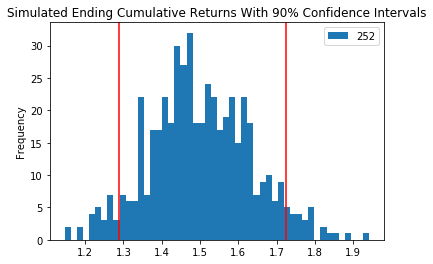

In [258]:
# Visualized projected Max Sharpe portfolio
cumulative_ret_max_sharpe = monte_carlo_max_sharpe.iloc[-1,:]
confidence_interval_max_sharpe= cumulative_ret_max_sharpe.quantile(q=[0.05,0.95])
cumulative_ret_max_sharpe.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval_max_sharpe.iloc[0],color='r')
plt.axvline(confidence_interval_max_sharpe.iloc[1],color='r')

In [259]:
confidence_interval_max_sharpe

0.05    1.288295
0.95    1.725782
Name: 252, dtype: float64

## Projected Return of Min Vol Portfolio

In [260]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252
monte_carlo_min_vol= pd.DataFrame()
simulated_price_df_min_vol= pd.DataFrame()

In [261]:
# Run the Monte Carlo Simulation for Max Sharpe Port
# "FDL 0.271674","IVE 0.000697","IVW 0.035717","MTUM 0.047394","QUAL 0.145971","SPY 0.151910","USMV 0.078003","SIZE 0.268635"

for simulations in range(number_simulations):
    simulated_fdl_prices=[last_day_fdl]
    simulated_ive_prices=[last_day_ive]
    simulated_ivw_prices=[last_day_ivw]
    simulated_mtum_prices=[last_day_mtum]
    simulated_qual_prices=[last_day_qual]
    simulated_size_prices=[last_day_size]    
    simulated_spy_prices=[last_day_spy]
    simulated_usmv_prices=[last_day_usmv]
    
    for days in range(number_records):
        simulated_fdl_price=simulated_fdl_prices[-1]*(1+np.random.normal(abs(funds_daily_return_fdl),abs(funds_return_vol_fdl)))
        simulated_ive_price =simulated_ive_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ive),abs(funds_return_vol_ive)))
        simulated_ivw_price =simulated_ivw_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ivw),abs(funds_return_vol_ivw)))
        simulated_mtum_price=simulated_mtum_prices[-1]*(1+np.random.normal(abs(funds_daily_return_mtum),abs(funds_return_vol_mtum)))
        simulated_qual_price=simulated_qual_prices[-1]*(1+np.random.normal(abs(funds_daily_return_qual),abs(funds_return_vol_qual)))
        simulated_size_price=simulated_size_prices[-1]*(1+np.random.normal(abs(funds_daily_return_size),abs(funds_return_vol_size)))
        simulated_spy_price =simulated_spy_prices[-1]*(1+np.random.normal(abs(funds_daily_return_spy),abs(funds_return_vol_spy)))
        simulated_usmv_price=simulated_usmv_prices[-1]*(1+np.random.normal(abs(funds_daily_return_usmv),abs(funds_return_vol_usmv)))  
        
        
        simulated_fdl_prices.append(simulated_fdl_price)
        simulated_ive_prices.append(simulated_ive_price)
        simulated_ivw_prices.append(simulated_ivw_price)
        simulated_mtum_prices.append(simulated_mtum_price)
        simulated_qual_prices.append(simulated_qual_price)
        simulated_size_prices.append(simulated_size_price)   
        simulated_spy_prices.append(simulated_spy_price)
        simulated_usmv_prices.append(simulated_usmv_price)
        
     
        
    simulated_price_df_min_vol["HD-FDL"]=simulated_fdl_prices
    simulated_price_df_min_vol["VL-IVE"]=simulated_ive_prices
    simulated_price_df_min_vol["GR-IVW"]=simulated_ivw_prices
    simulated_price_df_min_vol["MT-MTUM"]=simulated_mtum_prices
    simulated_price_df_min_vol["QL-QUAL"]=simulated_qual_prices
    simulated_price_df_min_vol["SC-SIZE"]=simulated_size_prices
    simulated_price_df_min_vol["SPY"]= simulated_spy_prices
    simulated_price_df_min_vol["LV-USMV"]=simulated_usmv_prices
    
    simulated_daily_returns_min_vol=simulated_price_df_min_vol.pct_change()
    weights_min_vol=[0.271674,0.000697,0.035717,0.047394,0.145971,0.268635,0.151910,0.078003]
    portfolio_daily_returns_min_vol =simulated_daily_returns_min_vol.dot(weights_min_vol)
    monte_carlo_min_vol[simulations]= (1+portfolio_daily_returns_min_vol.fillna(0)).cumprod()
   

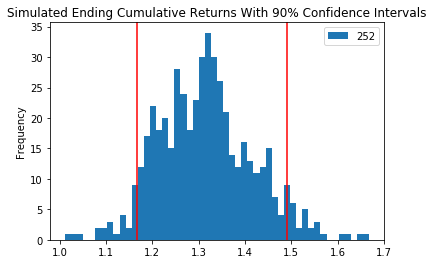

In [262]:
# Visualized projected Max Sharpe portfolio
cumulative_ret_min_vol = monte_carlo_min_vol.iloc[-1,:]
confidence_interval_min_vol= cumulative_ret_min_vol.quantile(q=[0.05,0.95])
cumulative_ret_min_vol.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval_min_vol.iloc[0],color='r')
plt.axvline(confidence_interval_min_vol.iloc[1],color='r')

In [263]:
confidence_interval_min_vol

0.05    1.167765
0.95    1.491898
Name: 252, dtype: float64

# 5. Data Insights/Reporting

## Tab 1: Passive vs Active Portfolios Performance

## Create Figures

In [264]:
funds_df.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_df = funds_df[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_return.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_return = funds_return[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]

In [265]:
# Cummulative Return
funds_return_cum = (1+funds_return).cumprod()
cum_return_plot = px.line(funds_return_cum,title="Cummulative Return")

In [266]:
# Correlation
correlation = funds_return.corr()
correlation_pandemic = funds_return_pandemic.corr()
correlation_hike_cycle = funds_return_hike_cycle.corr()
correlation_taper_tantrum = funds_return_taper_tantrum.corr()
corr_plot = px.imshow(correlation,title="Correlation 2013-current")
corr_pandemic_plot = px.imshow(correlation_pandemic,title="Correlation Mar 2020")
corr_hike_cycle_plot = px.imshow(correlation_hike_cycle,title="Correlation 2016-18")
corr_taper_tantrum_plot = px.imshow(correlation_taper_tantrum,title="Correlation 2013")

In [267]:
# Return Performance
total_return_all = round(ffn.core.calc_total_return(funds_df)*100,2)
total_return_3m = round(ffn.core.calc_total_return(funds_df_3m)*100,2)
total_return_taper_tantrum = round(ffn.core.calc_total_return(funds_df_taper_tantrum)*100,2)
total_return_pandemic = round(ffn.core.calc_total_return(funds_df_pandemic)*100,2)
total_return_hike_cycle = round(ffn.core.calc_total_return(funds_df_hike_cycle)*100,2)
total_return_scenarios = pd.concat([total_return_3m, total_return_taper_tantrum,total_return_pandemic,total_return_hike_cycle], axis = 1,keys=['Last 3M','Taper Tantum','Pandemic','Hike Cycle']).reset_index()
return_scenarios_plot = total_return_scenarios.hvplot.bar(title="Annualized Return by Scenarios")

In [268]:
# Max DD
mdd=ffn.core.calc_max_drawdown(funds_df_pandemic)
mdd_plot = px.bar(mdd,title ="Maximum Drawdown")

In [269]:
# Sharpe
vol_plot = px.bar(funds_return_std,title="Return Volatility")
funds_return_sharpe = round((funds_return.mean()*252)/(funds_return.std() * np.sqrt(252)),2)
sharpe_plot = px.bar(funds_return_sharpe,title="Sharpe Ratio")

## Create panel

In [270]:
# Create row
tab1_row1 = pn.Row(cum_return_plot,mdd_plot)
tab1_row2 = pn.Row(return_scenarios_plot)
tab1_row3 = pn.Row(vol_plot,sharpe_plot)
tab1_row4 = pn.Row(corr_plot,corr_hike_cycle_plot)
tab1_row5 = pn.Row(corr_taper_tantrum_plot,corr_pandemic_plot)

In [271]:
#Create column for tab 1
tab1 = pn.Column(
    '# Evaluation of active funds vs passive fund (2013-current)',
    '## In performance space, Momentum fund, Growth Fund, and Quality Fund outperform S&P500 in the past 7 years. Growth Fund and Quality Fund have smaller MDD compared to S&P500.',tab1_row1,
    '## Outperformance of Momentum fund is pretty robust under different scenarios, except in the past 3 months that Momentum Fund underperform S&P. Growth Fund and Small Cap Fund are the best performers in the past 3 months as propect of economic growth ir improving. ',tab1_row2,
    '## In term of tradeoff between risk and return, Momentum, Growth, Quality and Low Vol Funds offer better risk-return trade off compared to S&P index.',tab1_row3,
    '## All active funds have positive correlation to S&P500',tab1_row4,
    '## However, every funds correalted more with S&P during crisis time when volatility in the market spike. This could mean benefit of diversifying among passive/active could become lower under this scenario.',tab1_row5,
    '### Disclaimer: Summary of evaluation is based on daily price data back to 2013.')
tab1

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [3] Markdown(str)
    [4] Row
        [0] HoloViews(Bars)
    [5] Markdown(str)
    [6] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [7] Markdown(str)
    [8] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [9] Markdown(str)
    [10] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [11] Markdown(str)

## Tab 2: Suggested Optimal Allocation

## Create Figures

In [272]:
#Histogram
equal_weight_hist = px.histogram(cumulative_ret, title="1Y Projected Return: Equal-weighted Portfilio")
max_sharpe_hist = px.histogram(cumulative_ret_max_sharpe, title="1Y Projected Return: Max-Sharpe Portfilio")
min_vol_hist = px.histogram(cumulative_ret_min_vol, title="1Y Projected Return: Min-Vol Portfilio")

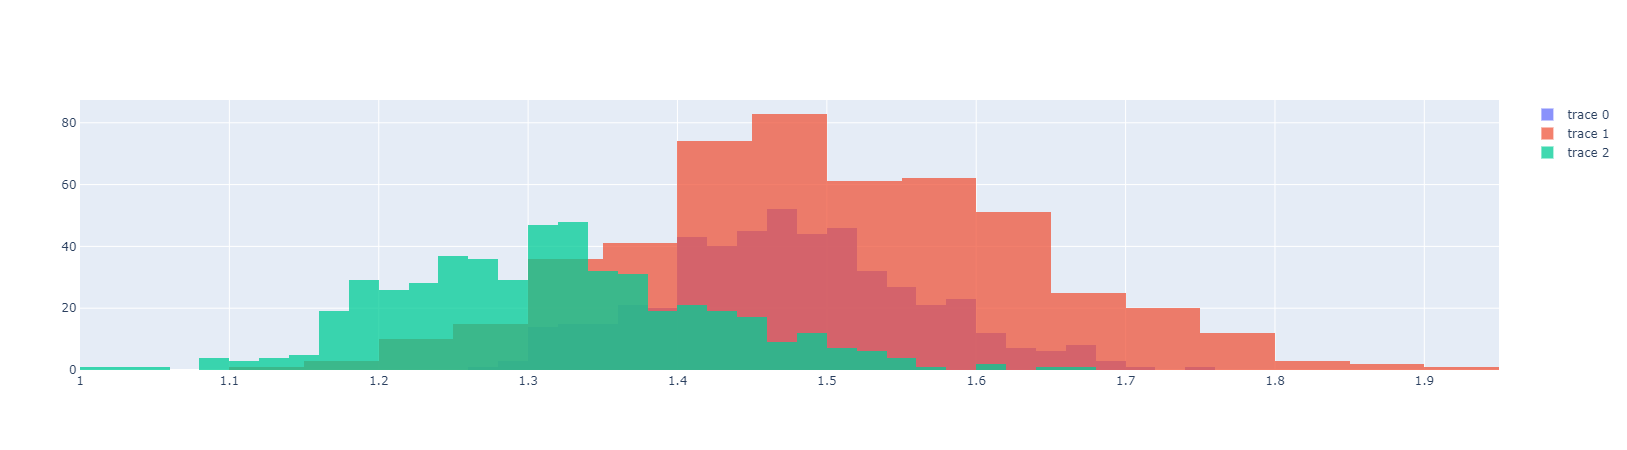

In [279]:
# Overlay histrogram
overlay_hist = go.Figure()
overlay_hist.add_trace(go.Histogram(x=cumulative_ret))
overlay_hist.add_trace(go.Histogram(x=cumulative_ret_max_sharpe))
overlay_hist.add_trace(go.Histogram(x=cumulative_ret_min_vol))
overlay_hist.update_layout(barmode='overlay')
overlay_hist.update_traces(opacity=0.75)

## Create panel

In [274]:
# Create row
tab2_row1 = max_sharpe_w_pie
tab2_row2 = min_vol_w_pie
tab2_row3 = pn.Row(equal_weight_hist,max_sharpe_hist,min_vol_hist)
tab2_row4 = pn.Row(overlay_hist)

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Matplotlib(Figure)
    [3] Markdown(str)
    [4] Matplotlib(Figure)
    [5] Markdown(str)
    [6] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [7] Markdown(str)
    [8] Row
        [0] Plotly(Figure)
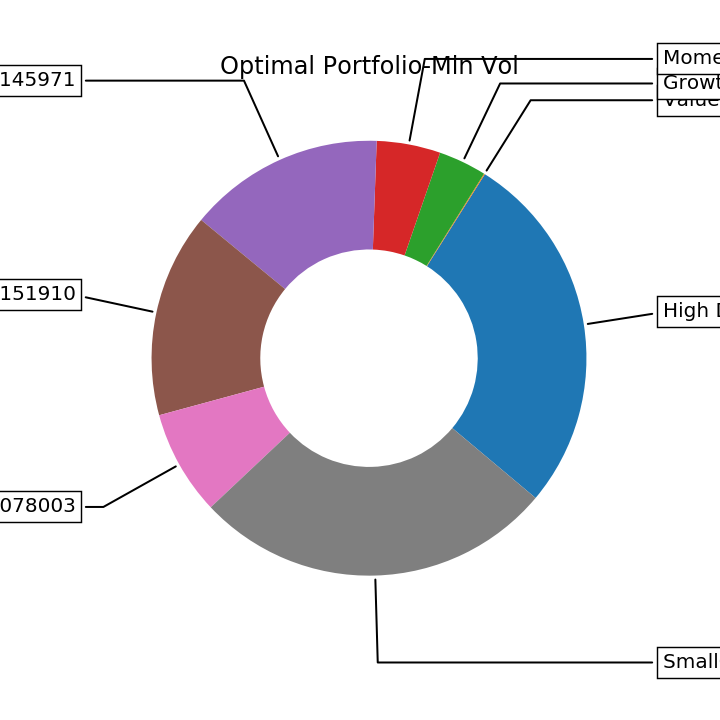
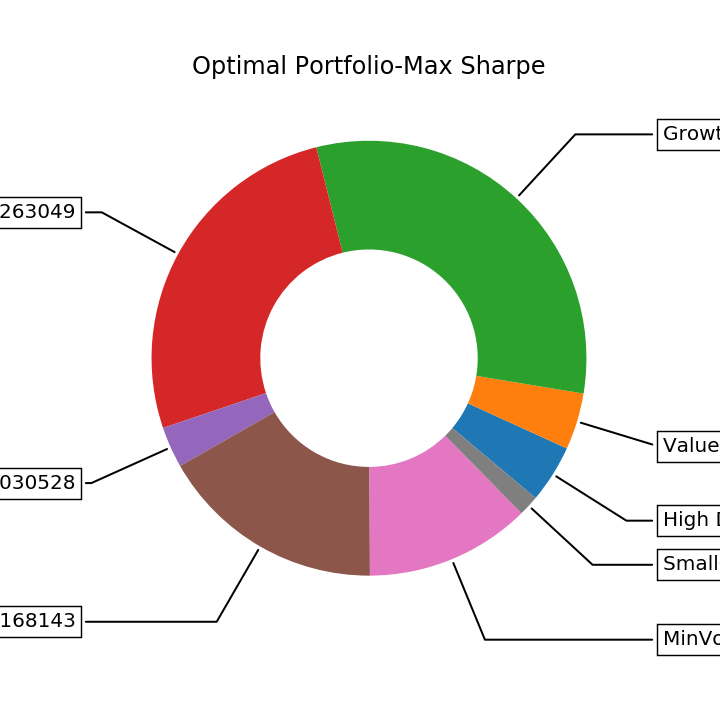

In [275]:
#Create column for tab 1
tab2 = pn.Column(
    '# Optimal Portfolio',
    '##Allocating more in Growth, Momentum and Quality funds yield optimal portfolio with maxmimum Sharpe ratio',tab2_row1,
    '##Meanwhile, allocating more in High Dividend fund give optimal portfolio with maxmimum Sharpe ratio',tab2_row2,
    '## ',tab2_row3,
    "## Compared to equal-weight portfoliom, Max-Sharpe portfolio can increase average return in 1Y-projected period while enhance upside gain. In contrast, Min-Vol would lower portfolio's volatiliry with the cost of lower return",tab2_row4)
tab2

# Data Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [3] Markdown(str)
        [4] Row
            [0] HoloViews(Bars)
        [5] Markdown(str)
        [6] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [7] Markdown(str)
        [8] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [9] Markdown(str)
        [10] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [11] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Matplotlib(Figure)
        [3] Markdown(str)
        [4] Matplotlib(Figure)
        [5] Markdown(str)
        [6] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
            [2] Plotly(Figure)
        [7] Markdown(str)
        [8] Row
            [0] Plotly(Figure)
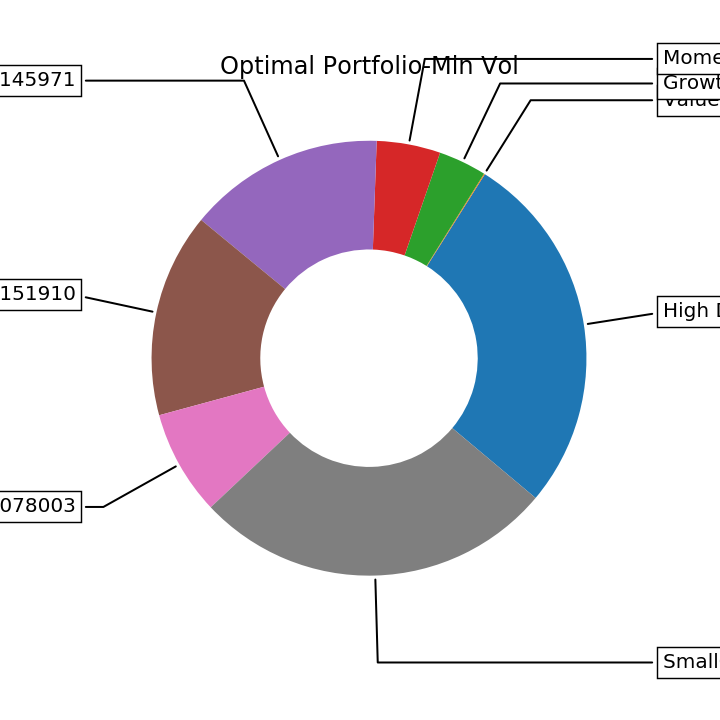
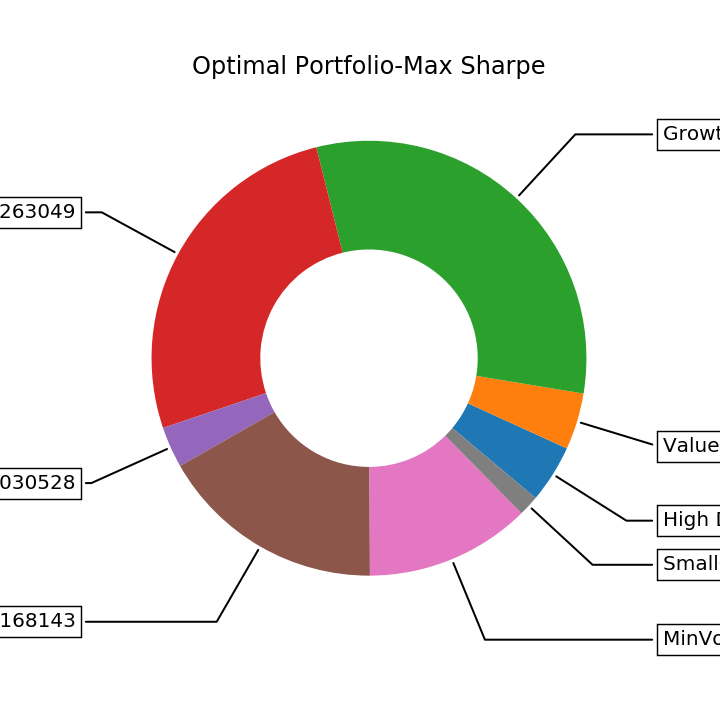

In [276]:
# Create tabs
tabs = pn.Tabs(
    ("Evaluation of active funds vs passive fund", tab1),
    ("Optimal Portfolio", tab2))
tabs